## Applied on PHS

In [1]:
import numpy as np
#import tensorflow as tf
from matplotlib import pyplot as plt
import glob
import random


In [2]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

## HS Profiles

In [3]:
path3="/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Eventcode/new_profile_singlePHS_projection/samples/"
hs_profile = np.load(path3+"Nside1024_singleHS_profile.npy")

# h(x) -> h(k)
h_frame = np.zeros( ( 720  ,  720 )) # Frame with zeros
h_frame[0:len(hs_profile),0:len(hs_profile)]+= hs_profile
np_rfft_hk=np.fft.rfft2(h_frame)


## Quicklens Map

In [4]:
path="./periodic_background/"
#tot = np.load(path+"1PHS6Events_Nside2048_d0_d80_BKG_"+str(0)+".npy")

qlbkgs = np.empty((0, 720, 720))
for evnts in range(1):
    temp = np.load(path+"500_events_720Sqr_lensed_uncutBackgroundlmax3500_"+str(evnts)+".npy")

    qlbkgs = np.concatenate((qlbkgs,temp))

In [5]:
qlbkgs_power = np.load(path+"500_events_720Sqr_lensed_uncutBackgroundlmax3500_1.npy")

In [6]:
# FFT average of multiple Backgrounds
fft_power = np.zeros((np_rfft_hk.shape[0],np_rfft_hk.shape[1]))
print((np_rfft_hk.shape[0],np_rfft_hk.shape[1]))
#fft_power = np.zeros((420,420))
for evnt in range(len(qlbkgs_power)):
    temp = qlbkgs_power[evnt]
    tempfft = np.fft.rfft2(temp)
    temppower = tempfft*np.conj(tempfft)
    fft_power = fft_power + temppower
    if not (evnt+1) % 500:
        print(str(evnt+1))
        
fft_power = np.real(fft_power)/len(qlbkgs)

(720, 361)
500


In [ ]:
len(qlbkgs)

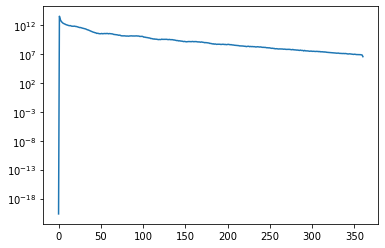

In [7]:
plt.plot(fft_power[0])
plt.yscale('log')

In [8]:
#import pandas as pd
#pd.DataFrame(hpfft_power).to_csv("./healpy_Pk.csv")

In [9]:
# FFT on bkg
qlfiltered_bkg = []
for evnts in range(len(qlbkgs)):
    tempfft = np.fft.rfft2(qlbkgs[evnts])
    tempfft[0,0]=0
    fft_power[fft_power<10**-10]=10**20
    tempfiltered = np.fft.irfft2(tempfft    * np_rfft_hk/fft_power)
    qlfiltered_bkg.append(tempfiltered)

qlfiltered_bkg = np.array(qlfiltered_bkg)

In [10]:
flat_qlfiltered_bkg = qlfiltered_bkg.flatten()

## Background Fitting

In [11]:
from scipy.stats import norm
from scipy.optimize import curve_fit

In [12]:
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

[-2.54550034e-10  6.39503042e-06  6.60020454e+07]


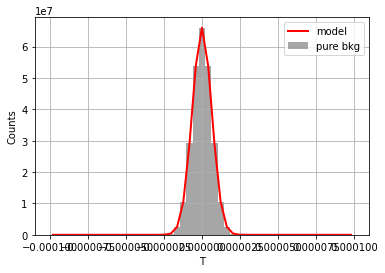

In [13]:
binsabs = np.linspace(-0.0001,0.0001,50)

n1, bins1, patches1 = plt.hist(flat_qlfiltered_bkg,binsabs,alpha = 0.7,color = 'grey',label = "pure bkg",density=False)

binsmid=((binsabs[1:]+binsabs[:-1])/2)

#         mu,sigma1,A
expected=(0.,0.00002,17000)
lowbound = 0
highbound = 60
params,cov=curve_fit(gauss,binsmid[lowbound:highbound],n1[lowbound:highbound],expected,maxfev=400000)
sigma=np.sqrt(np.diag(cov))

plt.plot(binsmid,gauss(binsmid,*params),color='red',lw=2,label='model')

print(params)

plt.legend()

#plt.yscale('log')
#plt.ylim(0, 10**5)
#plt.xlim(binsmid[lowbound:highbound][0],binsmid[lowbound:highbound][-1])
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

# Chi Square Method

## g = 6

In [14]:
# FFT on planted signals
pathsig = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/test_img/'

PHSsignals = []
for batch in range(1,4):
    temp = np.load(pathsig+"sig_larger/100_PHS_720sq_g1_Sig_onLSS_"+str(batch)+".npy")
    for evnt in range(len(temp)):
        PHSsignals.append(temp[evnt])

PHSsignals = np.array(PHSsignals)

rescale_val = 1
num_select = 25

In [15]:
selected_evnts = np.load('selected_rand_list_'+str(num_select)+'PHS.npy')

PHSsig = []
PHSsig_loc = []
for events in range(len(selected_evnts)):
    temp = 0
    temp_loc = []
    for num in range(num_select):
        temp += PHSsignals[selected_evnts[events,num]]
        test = PHSsignals[selected_evnts[events,num]]
        test_loc = np.where((test==test.max()))
        test_locx = int(np.mean(test_loc[0]))
        test_locy = int(np.mean(test_loc[1]))
        temp_loc.append([test_locx,test_locy])
    PHSsig.append(temp)
    PHSsig_loc.append(temp_loc)
    
PHSsig = rescale_val * np.array(PHSsig)
PHSsig_loc = np.array(PHSsig_loc)

In [16]:
#hpBkpSig = hpbkgs+PHSsig
qlBkpSig = qlbkgs[:500]+PHSsig


#hpBkpSigfilt = []
qlBkpSigfilt = []


for evnts in range(500):
    #hptempfft = np.fft.rfft2(hpBkpSig[evnts])
    qltempfft = np.fft.rfft2(qlBkpSig[evnts])
    qltempfft[0,0]=0
    
    fft_power[fft_power<10**-20]=10**20
    #hptempfiltered = np.fft.irfft2(hptempfft    *np_rfft_hk/hpfft_power)
    #qltempfiltered = np.fft.irfft2(qltempfft    * np.conjugate(np_rfft_hk)/qlfft_power)
    qltempfiltered = np.fft.irfft2(qltempfft    * np_rfft_hk/fft_power)
    #qltempfiltered = np.fft.irfft2((qltempfft    * np_rfft_hk/qlfft_power)[1:,1:])

    #hpBkpSigfilt.append(hptempfiltered)
    qlBkpSigfilt.append(qltempfiltered)
    
#hpBkpSigfilt = np.array(hpBkpSigfilt)
qlBkpSigfilt = np.array(qlBkpSigfilt)

#flat_hpBkpSigfilt = hpBkpSigfilt.flatten()
flat_qlBkpSigfilt = qlBkpSigfilt.flatten()

In [17]:
binsabs = np.linspace(-0.0004,0.0004,100)
binsabs = np.linspace(-0.0001,0.0001,50)

binsmid=((binsabs[1:]+binsabs[:-1])/2)

thres = 37
n1max = 45

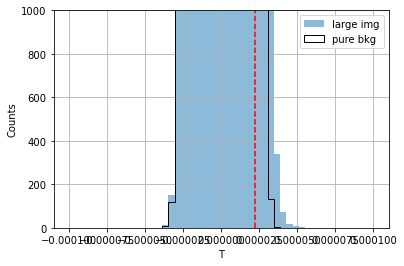

In [18]:
n2, bins2, patches2 = plt.hist(flat_qlBkpSigfilt,binsabs,alpha = 0.5,label = "large img",density=False)

n1, bins1, patches1 = plt.hist(flat_qlfiltered_bkg,binsabs,alpha = 1,histtype='step',color = 'black',label = "pure bkg",density=False)

#plt.axvline(binsabs[thres-1],color = 'red',linestyle = '--')
#plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

plt.axvline(binsabs[30],color = 'red',linestyle = '--')

plt.legend()

plt.ylim(0, 10**3)
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

In [19]:
np.set_printoptions(suppress=True)
n2

array([       0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        1.,       11.,      152.,     3552.,
          46672.,   424390.,  2603476., 10679954., 29306302., 53707760.,
       65707646., 53673485., 29273297., 10675528.,  2606124.,   431746.,
          51878.,     6233.,     1352.,      338.,       73.,       17.,
              9.,        4.,        0.,        0.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0.])

In [20]:
n1

array([       0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        1.,        7.,      120.,     3014.,
          42520.,   403447.,  2533342., 10550014., 29225869., 53847302.,
       65992820., 53844362., 29218090., 10558000.,  2531578.,   403830.,
          42567.,     2981.,      131.,        5.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0.])

In [21]:
print(np.sum(n2))
print(np.sum(n1))

thres = 37
n1max = 45
n2max = 50
print(n1[thres:n1max])
print(n2[thres:n1max])
print("d.o.f = "+str(len(n2[thres:n1max])-1))
np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])

259200000.0
259200000.0
[0. 0. 0. 0. 0. 0. 0. 0.]
[4. 0. 0. 0. 0. 0. 0. 0.]
d.o.f = 7


/tmp/ipykernel_2298481/113468219.py:10: RuntimeWarning: divide by zero encountered in true_divide
  np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])
/tmp/ipykernel_2298481/113468219.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])


nan

## g = 3

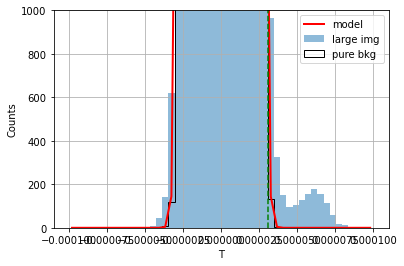

In [53]:
# FFT on planted signals
pathsig = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/test_img/'

PHSsignals = []
for batch in range(1,4):
    temp = np.load(pathsig+"sig_larger/100_PHS_720sq_g1_Sig_onLSS_"+str(batch)+".npy")
    for evnt in range(len(temp)):
        PHSsignals.append(temp[evnt])

PHSsignals = np.array(PHSsignals)

rescale_val = 3
num_select = 1

selected_evnts = np.load('selected_rand_list_'+str(num_select)+'PHS.npy')

PHSsig = []
PHSsig_loc = []
for events in range(len(selected_evnts)):
    temp = 0
    temp_loc = []
    for num in range(num_select):
        temp += PHSsignals[selected_evnts[events,num]]
        test = PHSsignals[selected_evnts[events,num]]
        test_loc = np.where((test==test.max()))
        test_locx = int(np.mean(test_loc[0]))
        test_locy = int(np.mean(test_loc[1]))
        temp_loc.append([test_locx,test_locy])
    PHSsig.append(temp)
    PHSsig_loc.append(temp_loc)

PHSsig = rescale_val * np.array(PHSsig)
PHSsig_loc = np.array(PHSsig_loc)


#hpBkpSig = hpbkgs+PHSsig
qlBkpSig = qlbkgs[:500]+PHSsig


#hpBkpSigfilt = []
qlBkpSigfilt = []


for evnts in range(500):
    #hptempfft = np.fft.rfft2(hpBkpSig[evnts])
    qltempfft = np.fft.rfft2(qlBkpSig[evnts])
    qltempfft[0,0]=0
    
    fft_power[fft_power<10**-20]=10**20
    #hptempfiltered = np.fft.irfft2(hptempfft    *np_rfft_hk/hpfft_power)
    #qltempfiltered = np.fft.irfft2(qltempfft    * np.conjugate(np_rfft_hk)/qlfft_power)
    qltempfiltered = np.fft.irfft2(qltempfft    * np_rfft_hk/fft_power)
    #qltempfiltered = np.fft.irfft2((qltempfft    * np_rfft_hk/qlfft_power)[1:,1:])

    #hpBkpSigfilt.append(hptempfiltered)
    qlBkpSigfilt.append(qltempfiltered)
    
#hpBkpSigfilt = np.array(hpBkpSigfilt)
qlBkpSigfilt = np.array(qlBkpSigfilt)

#flat_hpBkpSigfilt = hpBkpSigfilt.flatten()
flat_qlBkpSigfilt = qlBkpSigfilt.flatten()

binsabs = np.linspace(-0.0001,0.0001,50)

binsmid=((binsabs[1:]+binsabs[:-1])/2)

#thres = 37
#n1max = 45

n2, bins2, patches2 = plt.hist(flat_qlBkpSigfilt,binsabs,alpha = 0.5,label = "large img",density=False)

n1, bins1, patches1 = plt.hist(flat_qlfiltered_bkg,binsabs,alpha = 1,histtype='step',color = 'black',label = "pure bkg",density=False)

plt.plot(binsmid,gauss(binsmid,*params),color='red',lw=2,label='model')

thres = 33
plt.axvline(binsabs[thres-1],color = 'green',linestyle = '--')
#plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

plt.legend()

plt.ylim(0, 10**3)
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

In [23]:
n2

array([       0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0.,        7.,       44.,      142.,      619.,     4499.,
          46708.,   413470.,  2554282., 10577695., 29234371., 53810546.,
       65928525., 53803855., 29224012., 10582182.,  2551118.,   413675.,
          46893.,     4891.,      967.,      325.,      149.,       94.,
            105.,      130.,      155.,      177.,      156.,      112.,
             58.,       17.,       13.,        4.,        2.,        1.,
              0.])

In [24]:
n1

array([       0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        1.,        7.,      120.,     3014.,
          42520.,   403447.,  2533342., 10550014., 29225869., 53847302.,
       65992820., 53844362., 29218090., 10558000.,  2531578.,   403830.,
          42567.,     2981.,      131.,        5.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0.])

In [25]:
gauss(binsmid,*params)

array([       0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.00000007,
              0.00001207,        0.00130697,        0.09416116,
              4.51400437,      143.99130009,     3056.29036344,
          43165.52746998,   405661.29560325,  2536729.59413426,
       10555258.13461923, 29224535.88444601, 53840671.5316563 ,
       66002045.35180978, 53837935.93997057, 29221566.2199113 ,
       10553649.30944153,  2536214.07845982,   405558.24981335,
          43152.36995283,     3055.20351931,      143.93278205,
              4.51194062,        0.09411332,        0.00130624,
              0.00001206,        0.00000007,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.     

In [26]:
print(np.sum(n2))
print(np.sum(n1))

thres = 37
n1max = 45
n2max = 50
print(n1[thres:n1max])
print(n2[thres:n1max])
print("d.o.f = "+str(len(n2[thres:n1max])-1))
np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])

259199999.0
259200000.0
[0. 0. 0. 0. 0. 0. 0. 0.]
[130. 155. 177. 156. 112.  58.  17.  13.]
d.o.f = 7


/tmp/ipykernel_2298481/113468219.py:10: RuntimeWarning: divide by zero encountered in true_divide
  np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])


inf

## g = 2

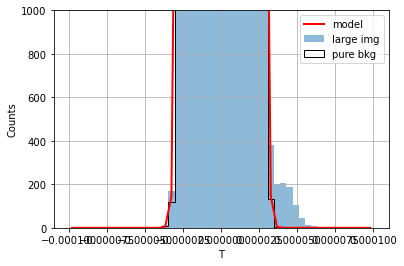

In [59]:
# FFT on planted signals
pathsig = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/test_img/'

PHSsignals = []
for batch in range(1,4):
    temp = np.load(pathsig+"sig_larger/100_PHS_720sq_g1_Sig_onLSS_"+str(batch)+".npy")
    for evnt in range(len(temp)):
        PHSsignals.append(temp[evnt])

PHSsignals = np.array(PHSsignals)

rescale_val = 2
num_select = 1

selected_evnts = np.load('selected_rand_list_'+str(num_select)+'PHS.npy')

PHSsig = []
PHSsig_loc = []
for events in range(len(selected_evnts)):
    temp = 0
    temp_loc = []
    for num in range(num_select):
        temp += PHSsignals[selected_evnts[events,num]]
        test = PHSsignals[selected_evnts[events,num]]
        test_loc = np.where((test==test.max()))
        test_locx = int(np.mean(test_loc[0]))
        test_locy = int(np.mean(test_loc[1]))
        temp_loc.append([test_locx,test_locy])
    PHSsig.append(temp)
    PHSsig_loc.append(temp_loc)
    
PHSsig = rescale_val * np.array(PHSsig)
PHSsig_loc = np.array(PHSsig_loc)


#hpBkpSig = hpbkgs+PHSsig
qlBkpSig = qlbkgs[:500]+PHSsig


#hpBkpSigfilt = []
qlBkpSigfilt = []


for evnts in range(500):
    #hptempfft = np.fft.rfft2(hpBkpSig[evnts])
    qltempfft = np.fft.rfft2(qlBkpSig[evnts])
    qltempfft[0,0]=0
    
    fft_power[fft_power<10**-20]=10**20
    #hptempfiltered = np.fft.irfft2(hptempfft    *np_rfft_hk/hpfft_power)
    #qltempfiltered = np.fft.irfft2(qltempfft    * np.conjugate(np_rfft_hk)/qlfft_power)
    qltempfiltered = np.fft.irfft2(qltempfft    * np_rfft_hk/fft_power)
    #qltempfiltered = np.fft.irfft2((qltempfft    * np_rfft_hk/qlfft_power)[1:,1:])

    #hpBkpSigfilt.append(hptempfiltered)
    qlBkpSigfilt.append(qltempfiltered)
    
#hpBkpSigfilt = np.array(hpBkpSigfilt)
qlBkpSigfilt = np.array(qlBkpSigfilt)

#flat_hpBkpSigfilt = hpBkpSigfilt.flatten()
flat_qlBkpSigfilt = qlBkpSigfilt.flatten()

#thres = 37
#n1max = 45

binsabs = np.linspace(-0.0001,0.0001,50)

binsmid=((binsabs[1:]+binsabs[:-1])/2)

n2, bins2, patches2 = plt.hist(flat_qlBkpSigfilt,binsabs,alpha = 0.5,label = "large img",density=False)

n1, bins1, patches1 = plt.hist(flat_qlfiltered_bkg,binsabs,alpha = 1,histtype='step',color = 'black',label = "pure bkg",density=False)

plt.plot(binsmid,gauss(binsmid,*params),color='red',lw=2,label='model')

#plt.axvline(binsabs[thres-1],color = 'red',linestyle = '--')
#plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

plt.legend()

plt.ylim(0, 10**3)
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

In [28]:
(n2)

array([       0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        4.,       21.,      218.,     3552.,
          44985.,   411752.,  2554350., 10582587., 29240572., 53808152.,
       65922308., 53801457., 29227322., 10585817.,  2552356.,   412816.,
          45519.,     4016.,      637.,      442.,      425.,      309.,
            228.,       81.,       45.,       19.,        1.,        1.,
              0.,        3.,        2.,        2.,        0.,        1.,
              0.])

In [29]:
(n1/500)[34:].sum()

0.0

In [42]:
#n2, bins2, patches2 = plt.hist(flat_qlBkpSigfilt,binsabs,alpha = 0.5,label = "large img")
#n1, bins1, patches1 = plt.hist(flat_qlfiltered_bkg,binsabs,alpha = 1,histtype='step',color = 'black',label = "pure bkg")

#thres = 68
#n1max = 45

#plt.axvline(binsabs[thres-1],color = 'red',linestyle = '--')
#plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

#plt.legend()

#plt.ylim(0, 1000)
#plt.xlabel('T')
#plt.ylabel('Counts')
#plt.grid(True)

In [43]:
#print(np.sum(n2[67:]))
#print(np.sum(n1[67:]))

In [82]:
evntnum = 3
xloc = PHSsig_loc[evntnum][0,0]
yloc = PHSsig_loc[evntnum][0,1]

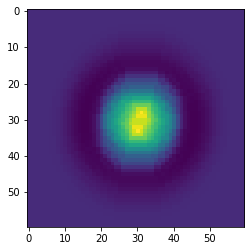

In [83]:
plt.imshow(PHSsig[evntnum][xloc-30:xloc+30,yloc-30:yloc+30])
plt.savefig('filtered_map/eta160_g2_sig_2.pdf',bbox_inches='tight')

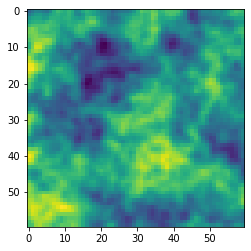

In [84]:
plt.imshow(qlBkpSig[evntnum][xloc-30:xloc+30,yloc-30:yloc+30])
plt.savefig('filtered_map/eta160_g2_sigbkg_2.pdf',bbox_inches='tight')

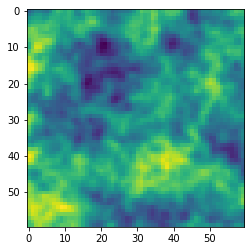

In [85]:
plt.imshow(qlbkgs[evntnum][xloc-30:xloc+30,yloc-30:yloc+30])
plt.savefig('filtered_map/eta160_g2_bkg_2.pdf',bbox_inches='tight')

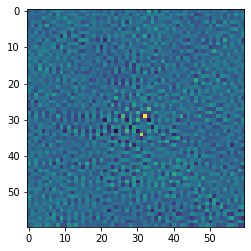

In [86]:
plt.imshow(qlBkpSigfilt[evntnum][xloc-30+25:xloc+30+25,yloc-30+25:yloc+30+25],cmap='viridis')
plt.savefig('filtered_map/eta160_g2_filtered_2.pdf',bbox_inches='tight')

In [41]:
print(np.sum(n2))
print(np.sum(n1))

thres = 30
n1max = 40
n2max = 50
print(n1[thres:n1max])
print(n2[thres:n1max])
print("d.o.f = "+str(len(n2[thres:n1max])-1))
np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])

259200000.0
259200000.0
[42567.  2981.   131.     5.     0.     0.     0.     0.     0.     0.]
[45519.  4016.   637.   442.   425.   309.   228.    81.    45.    19.]
d.o.f = 9


/tmp/ipykernel_2298481/4143925260.py:10: RuntimeWarning: divide by zero encountered in true_divide
  np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])


inf

In [30]:
print(np.sum(n2))
print(np.sum(n1))

thres = 29
n1max = 37
n2max = 50
print(n1[thres:n1max])
print(n2[thres:n1max])
print("d.o.f = "+str(len(n2[thres:n1max])-1))
np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])

123750.0
123749.99999999999
[0.         0.         0.         0.00477431 0.03914931 0.16423611
 0.72473958 2.77291667]
[0.         0.         0.         0.00381944 0.03628472 0.17951389
 0.73715278 2.84548611]
d.o.f = 7


/tmp/ipykernel_121002/2841332956.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])


nan

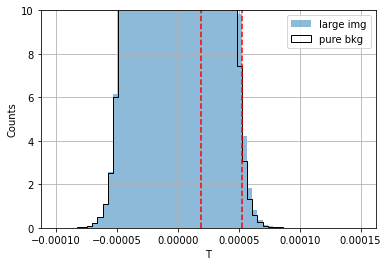

In [102]:
n2, bins2, patches2 = plt.hist(flat_hpBkpSigfilt,binsabs,alpha = 0.5,label = "large img",weights = 1/500*np.ones(len(flat_hpBkpSigfilt)))

n1, bins1, patches1 = plt.hist(flat_hpfiltered_bkg,binsabs,alpha = 1,histtype='step',color = 'black',label = "pure bkg",weights = 1/500*np.ones(len(flat_hpBkpSigfilt)))

plt.axvline(binsabs[thres-1],color = 'red',linestyle = '--')
plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

plt.legend()

plt.ylim(0, 10)
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

In [103]:
print(np.sum(n2))
print(np.sum(n1))

thres = 21
n1max = 29
n2max = 50
print(n1[thres:n1max])
print(n2[thres:n1max])
print("d.o.f = "+str(len(n2[thres:n1max])-1))
np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])

129959.99599989917
129959.99599989917
[14055.008      17513.04200002 19028.84199999 18009.11599996
 14858.38599997 10707.39199997  6765.01199998  3768.76599999]
[14020.982      17390.66000002 18855.70599999 17843.30799996
 14765.05599997 10693.96199998  6816.47599998  3837.91799999]
d.o.f = 7


6.302893776528178

## Pure Signal Only Check

In [ ]:
# FFT on planted signals
path2="/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/test_img/sig_larger/"

PHSsignals = []
for batch in range(1,6):
    temp = np.load(path2+"30_PHS_g1_Sig_onLSS_"+str(batch)+".npy")
    for evnt in range(len(temp)):
        PHSsignals.append(temp[evnt])

PHSsignals = np.array(PHSsignals)

rescale_val = 2
num_select = 1

selected_evnts = np.load('selected_rand_list_'+str(num_select)+'PHS.npy')

PHSsig = []
PHSsig_loc = []
for events in range(len(selected_evnts)):
    temp = 0
    temp_loc = []
    for num in range(num_select):
        temp += PHSsignals[selected_evnts[events,num]]
        test = PHSsignals[selected_evnts[events,num]]
        test_loc = np.where((test==test.max()))
        test_locx = int(np.mean(test_loc[0]))
        test_locy = int(np.mean(test_loc[1]))
        temp_loc.append([test_locx,test_locy])
    PHSsig.append(temp)
    PHSsig_loc.append(temp_loc)
    
PHSsig = rescale_val * np.array(PHSsig)
PHSsig_loc = np.array(PHSsig_loc)


#hpBkpSig = hpbkgs+PHSsig
qlBkpSig = PHSsig[:,:360,:360]


#hpBkpSigfilt = []
qlBkpSigfilt = []


for evnts in range(500):
    #hptempfft = np.fft.rfft2(hpBkpSig[evnts])
    qltempfft = np.fft.rfft2(qlBkpSig[evnts])
    qltempfft[0,0]=0
    
    fft_power[fft_power<10**-10]=10**20
    #hptempfiltered = np.fft.irfft2(hptempfft    *np_rfft_hk/hpfft_power)
    #qltempfiltered = np.fft.irfft2(qltempfft    * np.conjugate(np_rfft_hk)/qlfft_power)
    qltempfiltered = np.fft.irfft2(qltempfft    * np_rfft_hk/fft_power)
    #qltempfiltered = np.fft.irfft2((qltempfft    * np_rfft_hk/qlfft_power)[1:,1:])

    #hpBkpSigfilt.append(hptempfiltered)
    qlBkpSigfilt.append(qltempfiltered)
    
#hpBkpSigfilt = np.array(hpBkpSigfilt)
qlBkpSigfilt = np.array(qlBkpSigfilt)

#flat_hpBkpSigfilt = hpBkpSigfilt.flatten()
flat_qlBkpSigfilt = qlBkpSigfilt.flatten()

#thres = 37
#n1max = 45

n2, bins2, patches2 = plt.hist(flat_qlBkpSigfilt,binsabs,alpha = 0.5,label = "large img",density=True)

n1, bins1, patches1 = plt.hist(flat_qlfiltered_bkg,binsabs,alpha = 1,histtype='step',color = 'black',label = "pure bkg",density=True)

#plt.axvline(binsabs[thres-1],color = 'red',linestyle = '--')
#plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

plt.legend()

plt.ylim(0, 10)
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

In [ ]:
evntnum = 6
xloc = PHSsig_loc[evntnum][0,0]
yloc = PHSsig_loc[evntnum][0,1]

In [ ]:
plt.imshow(PHSsig[evntnum][xloc-30:xloc+30,yloc-30:yloc+30])

In [ ]:
plt.imshow(qlBkpSigfilt[evntnum][xloc-30+25:xloc+30+25,yloc-30+25:yloc+30+25],cmap='viridis')
plt.colorbar()

In [94]:
'''num_select = 25
selected_evnts = []

for tries in range(500):
    gen_list = np.random.choice(range(0,150), num_select, replace = False).reshape(-1,num_select)
    selected_evnts.append(gen_list[0])

selected_evnts = np.array(selected_evnts)
np.save("selected_rand_list_"+str(num_select)+"PHS",selected_evnts)
'''

'num_select = 25\nselected_evnts = []\n\nfor tries in range(500):\n    gen_list = np.random.choice(range(0,150), num_select, replace = False).reshape(-1,num_select)\n    selected_evnts.append(gen_list[0])\n\nselected_evnts = np.array(selected_evnts)\nnp.save("selected_rand_list_"+str(num_select)+"PHS",selected_evnts)\n'